# IP를 이용한 훼손 영역에 대한 검출 가능성 보이기

## 1. 모델 설계

모델은 다음의 3가지 과정을 거친다.

> 색공간 변경 -> 임계처리 -> 모폴로지

In [1]:
import numpy as np
import cv2

# --------------------------------

def convertColorSpace(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

def threshold(frame):
    # HSV 색공간을 이용. 채도와 밝기가 낮은 곳을 선택함. (==그림자)
    range_lower = (  0,  0,  0)
    range_upper = (255, 96, 92)
    return cv2.inRange(frame, range_lower, range_upper)

def morphology(frame):
    frame = cv2.morphologyEx(frame, cv2.MORPH_CLOSE, (5,5))
    return cv2.morphologyEx(frame, cv2.MORPH_OPEN, (5,5))

# --------------------------------

file_path_list = [
    './res/partial_01.JPG',
    './res/partial_p_01.JPG',
    './res/total_01.JPG'
]

sequence = [
    convertColorSpace,
    threshold,
    morphology
]

# --------------------------------

def model(src, sequence):
    retval = src
    for proc in sequence:
        retval = proc(retval)
    return retval

# --------------------------------

original = cv2.imread(file_path_list[0])

result = model(original, sequence)

## 2. 결과 출력

위 셀에서 얻은 결과 `result`와 원본 이미지를 비교 출력한다.

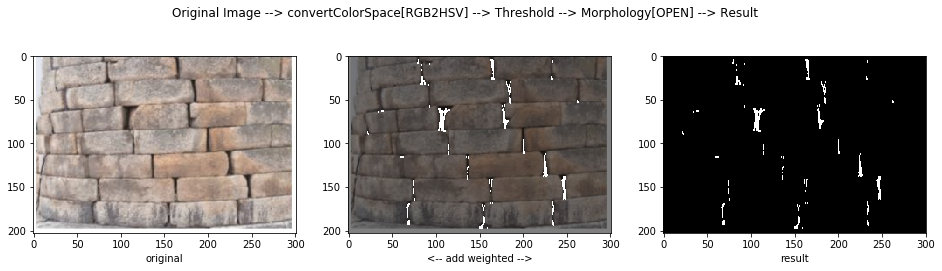

In [2]:
# 위 코드에 이어서...

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(16,4))
fig.suptitle('Original Image --> convertColorSpace[RGB2HSV] --> Threshold --> Morphology[OPEN] --> Result')

# Plot 0
axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axs[0].set_xlabel('original')

# Plot 1
axs[1].imshow(cv2.cvtColor(cv2.add(original//2, cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)), cv2.COLOR_BGR2RGB))
axs[1].set_xlabel('<-- add weighted -->')

# Plot 2
axs[2].imshow(result, cmap='gray')
axs[2].set_xlabel('result')

plt.show()

## 3. 훼손 영역 검출

앞선 과정들에서 얻은 결과 `result`에는 **(균열로 인하여 생긴) 그림자에 대한 마스크 이미지**가 담겨있다.  
  
다음 코드에서는 1. 이들에 대한 윤곽선을 검출하고, 2. 그 넓이에 임계치를 주어 훼손된 영역인지를 가린다.

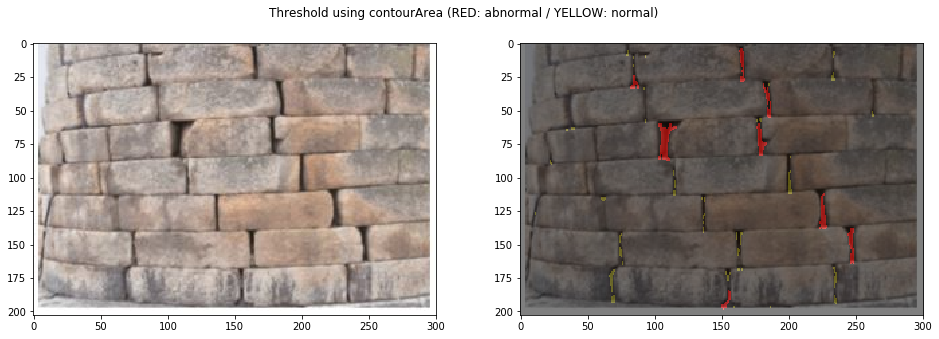

In [3]:
# 위 코드에 이어서...

MIN_CONT_AREA = 20

# --------------------------------

# 윤곽선 면적에도 임계를 주어 훼손여부를 가림.
mask = np.zeros(original.shape, dtype=np.uint8)
contours = cv2.findContours(result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

for cont in contours:
    # 임계치를 넘는다면, 붉은 색으로 처리: 훼손된 영역
    if cv2.contourArea(cont) >= MIN_CONT_AREA:
        cv2.drawContours(mask, [cont], -1, (0,0,255), -1)

    # 임계치를 넘지 못한다면, 노란색으로 처리
    else:
        cv2.drawContours(mask, [cont], -1, (0,128,128), -1)

# --------------------------------

fig, axs = plt.subplots(1,2, figsize=(16,5))
fig.suptitle('Threshold using contourArea (RED: abnormal / YELLOW: normal)')

axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(cv2.add(original//2, mask//2), cv2.COLOR_BGR2RGB))

plt.show()

## 4. 다음 연구로의 데이터 전달

In [4]:
import os

DATA_STR_PATH = "./data/"

# --------------------------------

if not os.path.exists(DATA_STR_PATH): os.mkdir(DATA_STR_PATH)

for file_path in file_path_list:
    original = cv2.imread(file_path)
    result   = model(original, sequence)

    file_name, file_extension = os.path.splitext(os.path.basename(file_path))

    cv2.imwrite(f"{DATA_STR_PATH}{file_name}{file_extension}", original)
    cv2.imwrite(f"{DATA_STR_PATH}{file_name}_mask{file_extension}", result)

with open(f"{DATA_STR_PATH}.datalist", "w") as f:
    file_basename_list = [os.path.basename(file_path) for file_path in file_path_list]
    f.write('\n'.join(file_basename_list))